## Imports

In [ ]:
!pip install xgboost
!pip install statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.metrics import mean_absolute_percentage_error
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb

     |████████████████████████████████| 166.7 MB 69.4 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 9.5 MB 27.5 MB/s 
     |████████████████████████████████| 231 kB 71.8 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
2021-09-16 11:05:16.270140: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 11:05:16.270182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
df_drop = pd.read_csv('/work/datasets/df_drop.csv')

In [ ]:
# Moving Average calculation

for i in range(1, len(df_drop)):
    df_drop.loc[i, 'awaken_min'] = (df_drop.loc[i-1, 'awaken_min']*i + df_drop.loc[i, 'awaken_min'])/(i+1)
for i in range(1, len(df_drop)):
    df_drop.loc[i, 'awaken_moments'] = (df_drop.loc[i-1, 'awaken_moments']*i + df_drop.loc[i, 'awaken_moments'])/(i+1)
for i in range(len(df_drop)-1,0,-1):
    df_drop.loc[i, 'awaken_min'] = df_drop.loc[i-1, 'awaken_min']
for i in range(len(df_drop)-1,0,-1):
    df_drop.loc[i, 'awaken_moments'] = df_drop.loc[i-1, 'awaken_moments']

for i in range(1, len(df_drop)):
    df_drop.loc[i, 'sleep_efficiency'] = (df_drop.loc[i-1, 'sleep_efficiency']*i + df_drop.loc[i, 'sleep_efficiency'])/(i+1)
for i in range(len(df_drop)-1,0,-1):
    df_drop.loc[i, 'sleep_efficiency'] = df_drop.loc[i-1, 'sleep_efficiency']

In [ ]:
df_drop = df_drop.iloc[1: ]

In [ ]:
df_drop.head(10)

,Unnamed: 0,userId,bmi,isi,age,month,date,sleep_start_time,sleep_end_time,sleep_min,...,awaken_min,awaken_moments,cal_consume,active_cal,walks,distance,stairs,active_ratio,nap_total_freq,nap_total_time
1,1,1,16.2,17,20,4,24,1833.0,2170.0,287.0,...,19.000000,21.000000,1761,755,11712,8.05,19,0.2302,1.0,139.0
2,2,1,16.2,17,20,4,25,1526.0,2003.0,413.0,...,34.500000,20.500000,1850,868,12898,8.72,8,0.2473,0.0,0.0
3,3,1,16.2,17,20,4,26,1593.0,1941.0,293.0,...,44.333333,23.000000,1795,805,12306,8.25,20,0.2749,0.0,0.0
4,4,1,16.2,17,20,4,27,1532.0,1912.0,329.0,...,47.000000,23.750000,1848,894,9207,6.16,15,0.2891,0.0,0.0
5,5,1,16.2,17,20,4,28,1619.0,1989.0,341.0,...,47.800000,24.400000,1997,1097,12121,8.06,20,0.3648,0.0,0.0
6,6,1,16.2,17,20,4,29,1564.0,1933.0,331.0,...,44.666667,25.166667,1479,403,3740,2.49,6,0.1630,1.0,62.0
7,7,1,16.2,17,20,4,30,1570.0,1899.0,282.0,...,43.714286,24.142857,1681,662,9657,6.42,15,0.2146,0.0,0.0
8,8,1,16.2,17,20,5,1,1477.0,2050.0,490.0,...,44.125000,25.000000,1683,656,9420,6.26,11,0.2041,0.0,0.0
9,9,1,16.2,17,20,5,2,1455.0,1741.0,253.0,...,48.444444,26.000000,1672,635,9961,6.72,13,0.2327,0.0,0.0
10,10,1,16.2,17,20,5,3,1579.0,1922.0,299.0,...,46.900000,25.100000,1626,593,8578,5.80,30,0.1954,1.0,101.0


In [ ]:
df_drop.corr()['sleep_min'].sort_values(ascending=False)

sleep_min           1.000000
sleep_end_time      0.456558
walks               0.066792
distance            0.062364
awaken_moments      0.060781
active_ratio        0.053862
month               0.035546
stairs              0.034034
age                 0.033403
awaken_min          0.032929
active_cal          0.027967
isi                 0.013534
cal_consume        -0.008318
Unnamed: 0         -0.009828
userId             -0.011181
date               -0.043192
sleep_efficiency   -0.058055
bmi                -0.092203
nap_total_time     -0.136778
nap_total_freq     -0.150674
sleep_start_time   -0.354385
Name: sleep_min, dtype: float64

In [ ]:
X = df_drop.drop(['sleep_min', 'stairs', 'userId', 'date', 'month', 'Unnamed: 0', 'sleep_start_time'], axis=1).values
y = df_drop['sleep_min'].values
print(X.shape, y.shape)

(1675, 14) (1675,)


## Train Validation Test Split

In [ ]:
# Train Test Split

x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

In [ ]:
# Train Validation Split

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1205, 1)
(302, 1)
(168, 1)


In [ ]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

X_train = input_scaler.transform(X_train)
y_train = output_scaler.transform(y_train)

X_val = input_scaler.transform(X_test)
y_val = output_scaler.transform(y_test)

X_test = input_scaler.transform(X_test)
y_test = output_scaler.transform(y_test)

### OLS Regression

In [ ]:
data = df_drop.drop(['sleep_min', 'stairs', 'userId', 'date', 'month', 'Unnamed: 0', 'sleep_start_time'], axis=1)
data.columns

Index(['bmi', 'isi', 'age', 'sleep_end_time', 'sleep_efficiency', 'awaken_min',
       'awaken_moments', 'cal_consume', 'active_cal', 'walks', 'distance',
       'active_ratio', 'nap_total_freq', 'nap_total_time'],
      dtype='object')

In [ ]:
x = sm.add_constant(X_train)
ols = sm.OLS(y_train, x)
est = ols.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     29.90
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           2.69e-68
Time:                        11:05:28   Log-Likelihood:                 832.12
No. Observations:                1205   AIC:                            -1634.
Df Residuals:                    1190   BIC:                            -1558.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1981      0.128      1.546      0.1

### Linear Regression

In [ ]:
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)
pred_val_lr = lr_regressor.predict(X_val)
pred_test_lr = lr_regressor.predict(X_test)

### Decision Tree Regression

In [ ]:
# Hyperparameter tuning

dt_regressor = DecisionTreeRegressor()
parameters={"splitter":["best","random"],
            "max_depth" : [10, 15, 20, 25],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30]}

tuning_model=GridSearchCV(dt_regressor,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
tuning_model.fit(X_train,y_train)

[CV 1/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, splitter=random;, score=-0.018 total time=   0.0s
[CV 2/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, splitter=random;, score=-0.020 total time=   0.0s
[CV 3/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=4, splitter=random;, score=-0.016 total time=   0.0s
[CV 1/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, splitter=best;, score=-0.025 total time=   0.0s
[CV 2/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, splitter=best;, score=-0.021 total time=   0.0s
[CV 3/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, splitter=best;, score=-0.016 total time=   0.0s
[CV 1/3] END max_depth=20, max_features=None, max_leaf_nodes=30, min_samples_leaf=5, splitter=random;, score=-0.032 total time=   0.0s
[CV 2/3] END max_depth=20, max_features=None, max_leaf_nodes=

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 15, 20, 25],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=3)

In [ ]:
tuning_model.best_params_

{'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 3,
 'splitter': 'random'}

In [ ]:
dt_regressor = DecisionTreeRegressor(max_depth = 15, criterion = 'mse', max_features= None, max_leaf_nodes= 10, min_samples_leaf= 3, splitter='random', random_state = 1)
dt_regressor.fit(X_train, y_train)
pred_val_dt = dt_regressor.predict(X_val)
pred_test_dt = dt_regressor.predict(X_test)

### Random Forest Regression

In [ ]:
# Hyperparameter Tuning

rf = RandomForestRegressor(random_state = 35)

random_grid = {'n_estimators': [100, 200, 300, 400, 500], 
               'max_features': ['auto', 'sqrt'], 
               "max_depth" : [10, 15, 20, 25],
               "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
               'bootstrap': [True, False]}


rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train,y_train)

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_l

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=35),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=35, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 25,
 'bootstrap': True}

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, criterion = 'mse', random_state = 1, bootstrap= True, max_depth=25, max_features='sqrt', min_samples_leaf=2)
rf.fit(X_train, y_train)
pred_val_rf = rf.predict(X_val)
pred_test_rf = rf.predict(X_test)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Linear Support Vector Regression

In [ ]:
svr = LinearSVR(random_state=1)
svr.fit(X_train, y_train)
pred_val_svr = svr.predict(X_val)
pred_test_svr = svr.predict(X_test)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### XGBoost

In [ ]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)
pred_val_xgb = xgb_regressor.predict(X_val)
pred_test_xgb = xgb_regressor.predict(X_test)

### Accuracy and Errors

In [ ]:
pred_val_dt = pred_val_dt.reshape(-1, 1)
pred_val_rf = pred_val_rf.reshape(-1, 1)
pred_val_svr = pred_val_svr.reshape(-1, 1)
pred_val_xgb = pred_val_xgb.reshape(-1, 1)

pred_test_dt = pred_val_dt.reshape(-1, 1)
pred_test_rf = pred_val_rf.reshape(-1, 1)
pred_test_svr = pred_test_svr.reshape(-1, 1)
pred_test_xgb = pred_test_xgb.reshape(-1, 1)

In [ ]:
pred_val_lr = scaler_y.inverse_transform(pred_val_lr)
pred_val_dt = scaler_y.inverse_transform(pred_val_dt)
pred_val_rf = scaler_y.inverse_transform(pred_val_rf)
pred_val_svr = scaler_y.inverse_transform(pred_val_svr)
pred_val_xgb = scaler_y.inverse_transform(pred_val_xgb)

pred_test_lr = scaler_y.inverse_transform(pred_test_lr)
pred_test_dt = scaler_y.inverse_transform(pred_test_dt)
pred_test_rf = scaler_y.inverse_transform(pred_test_rf)
pred_test_svr = scaler_y.inverse_transform(pred_test_svr)
pred_test_xgb = scaler_y.inverse_transform(pred_test_xgb)

y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [ ]:
Algo = []
R2_score = []
MAE = []
MAPE = []

In [ ]:
# Linear Regression
Algo.append('Linear Regression')
R2_score.append(r2_score(y_true=y_val, y_pred=pred_val_lr))
MAE.append(mean_absolute_error(y_true=y_val, y_pred=pred_val_lr))
MAPE.append(mean_absolute_percentage_error(y_true=y_val, y_pred=pred_val_lr).numpy().mean())

# Decision Tree Regression
Algo.append('Decision Tree Regression')
R2_score.append(r2_score(y_true=y_val, y_pred=pred_val_dt))
MAE.append(mean_absolute_error(y_true=y_val, y_pred=pred_val_dt))
MAPE.append(mean_absolute_percentage_error(y_true=y_val, y_pred=pred_val_dt).numpy().mean())

# Random Forest Regression
Algo.append('Random Forest Regression')
R2_score.append(r2_score(y_true=y_val, y_pred=pred_val_rf))
MAE.append(mean_absolute_error(y_true=y_val, y_pred=pred_val_rf))
MAPE.append(mean_absolute_percentage_error(y_true=y_val, y_pred=pred_val_rf).numpy().mean())

# Linear Support Vector Regression
Algo.append('Linear Support Vector Regression')
R2_score.append(r2_score(y_true=y_val, y_pred=pred_val_svr))
MAE.append(mean_absolute_error(y_true=y_val, y_pred=pred_val_svr))
MAPE.append(mean_absolute_percentage_error(y_true=y_val, y_pred=pred_val_svr).numpy().mean())

# XGBoost
Algo.append('XGBoost')
R2_score.append(r2_score(y_true=y_val, y_pred=pred_val_xgb))
MAE.append(mean_absolute_error(y_true=y_val, y_pred=pred_val_xgb))
MAPE.append(mean_absolute_percentage_error(y_true=y_val, y_pred=pred_val_xgb).numpy().mean())

2021-09-16 11:05:49.432874: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 11:05:49.436514: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-16 11:05:49.436534: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-16 11:05:49.436553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-a0e08efc-e855-4fc3-ac3b-2717145dc2a0): /proc/driver/nvidia/version does not exist
2021-09-16 11:05:49.438295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operatio

In [ ]:
Comparison_Val = pd.DataFrame(list(zip(Algo, R2_score, MAE, MAPE)), columns = ['Algorithm', 'R2 Score', 'MAE', 'MAPE'])

In [ ]:
Algo = []
R2_score = []
MAE = []
RMSE = []
MAPE = []

In [ ]:
# Linear Regression
Algo.append('Linear Regression')
R2_score.append(r2_score(y_true=y_test, y_pred=pred_test_lr))
MAE.append(mean_absolute_error(y_true=y_test, y_pred=pred_test_lr))
MAPE.append(mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test_lr).numpy().mean())

# Decision Tree Regression
Algo.append('Decision Tree Regression')
R2_score.append(r2_score(y_true=y_test, y_pred=pred_test_dt))
MAE.append(mean_absolute_error(y_true=y_test, y_pred=pred_test_dt))
MAPE.append(mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test_dt).numpy().mean())

# Random Forest Regression
Algo.append('Random Forest Regression')
R2_score.append(r2_score(y_true=y_test, y_pred=pred_test_rf))
MAE.append(mean_absolute_error(y_true=y_test, y_pred=pred_test_rf))
MAPE.append(mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test_rf).numpy().mean())

# Linear Support Vector Regression
Algo.append('Linear Support Vector Regression')
R2_score.append(r2_score(y_true=y_test, y_pred=pred_test_svr))
MAE.append(mean_absolute_error(y_true=y_test, y_pred=pred_test_svr))
MAPE.append(mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test_svr).numpy().mean())

# XGBoost
Algo.append('XGBoost')
R2_score.append(r2_score(y_true=y_test, y_pred=pred_test_xgb))
MAE.append(mean_absolute_error(y_true=y_test, y_pred=pred_test_xgb))
MAPE.append(mean_absolute_percentage_error(y_true=y_test, y_pred=pred_test_xgb).numpy().mean())

In [ ]:
Comparison_Test = pd.DataFrame(list(zip(Algo, R2_score, MAE, MAPE)), columns = ['Algorithm', 'R2 Score', 'MAE', 'MAPE'])

### Results

In [ ]:
print("Validation Set Accuracy")
Comparison_Val.head()

Validation Set Accuracy


,Algorithm,R2 Score,MAE,MAPE
0,Linear Regression,-9.802672e+06,370.791490,98584.046224
1,Decision Tree Regression,-1.011909e+07,378.474820,101994.343797
2,Random Forest Regression,-9.725216e+06,368.300313,97463.227393
3,Linear Support Vector Regression,-9.775795e+06,369.892812,98205.260959
4,XGBoost,-7.231785e+06,313.785782,82868.179688


In [ ]:
print("Test Set Accuracy")
Comparison_Test.head()

Test Set Accuracy


,Algorithm,R2 Score,MAE,MAPE
0,Linear Regression,0.097289,67.374500,25.768569
1,Decision Tree Regression,-0.103950,76.578235,29.728598
2,Random Forest Regression,0.123763,67.238224,25.165809
3,Linear Support Vector Regression,0.101087,67.418050,25.644107
4,XGBoost,-0.227577,81.438432,25.785807


### Charts

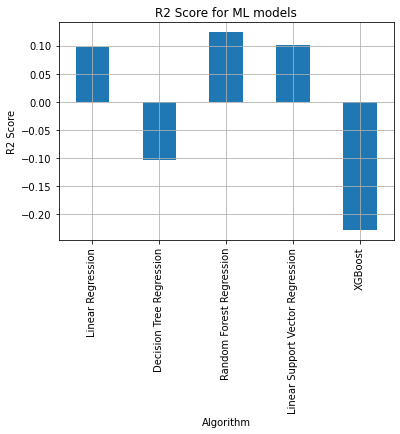

In [ ]:
# R2 Score

ax = Comparison_Test['R2 Score'].plot(kind="bar")
ax.set_title("R2 Score for ML models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("R2 Score")
ax.set_xticklabels(Comparison_Test['Algorithm'])

plt.grid()
plt.show()

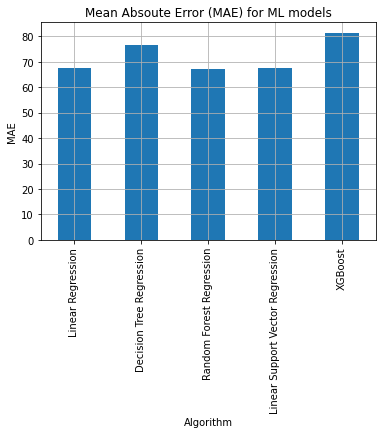

In [ ]:
# MAE

ax = Comparison_Test['MAE'].plot(kind="bar")
ax.set_title("Mean Absoute Error (MAE) for ML models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("MAE")
ax.set_xticklabels(Comparison_Test['Algorithm'])

plt.grid()
plt.show()

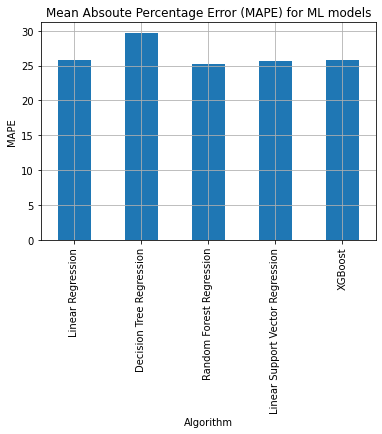

In [ ]:
# MAPE

ax = Comparison_Test['MAPE'].plot(kind="bar")
ax.set_title("Mean Absoute Percentage Error (MAPE) for ML models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("MAPE")
ax.set_xticklabels(Comparison_Test['Algorithm'])

plt.grid()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a0e08efc-e855-4fc3-ac3b-2717145dc2a0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>